<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix

!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 7.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.1
    Uninstalling nbformat-5.7.1:
      Successfully uninstalled nbformat-5.7.1


In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-01-28 20:52:12--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-01-28 20:52:12--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  37.7MB/s    in 12s     

2023-01-28 20:52:25 (36.3 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

In [4]:
import os

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)


100%|██████████| 101/101 [02:26<00:00,  1.46s/it]


In [5]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label = Y['train']
      else:
          self.data = X['test']
          self.label = Y['test']
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        #flip x
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=0)
        
        #flip y
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        vox_g = rotate(vox_g, axes=(0, 1), angle=angle, cval=0.0, reshape=False)  
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [6]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

In [7]:
from collections import OrderedDict
class BatchVoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('batch2', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

In [8]:
from collections import OrderedDict
class DMPVoxNet(nn.Module):
    def __init__(self, n_classes=10, data_size=32):
        super().__init__()
        self.n_classes = n_classes
        self.data_size = data_size
        input_shape = (self.data_size,self.data_size,self.data_size)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(2)),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, self.n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

In [16]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      if hyperparameters["model"] == "VoxNet":
          self.model = VoxNet()
      elif hyperparameters["model"] == "BatchVoxNet":
          self.model = BatchVoxNet()
      else:
          self.model = DMPVoxNet()
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.loss_fn = nn.CrossEntropyLoss()
      self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          self.lr_scheduler.step()
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data[0], data[1]
              inputs = inputs.to(self.device)
              labels = labels.to(self.device)

              self.opt.zero_grad()
              pred = self.model(inputs)  # torch.Size([256, 10])
              loss = self.loss_fn(pred,labels)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(pred, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              pred_choice = pred.data.max(1)[1]
              correct = pred_choice.eq(labels.data).cpu().sum()
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample[0], sample[1]
                inputs_test = inputs_test.to(self.device)
                labels_test = labels_test.to(self.device)
                inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
                
                pred_test = self.model(inputs_test)
                loss_test = self.loss_fn(pred_test, labels_test)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = pred_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

**VoxNet** training

In [17]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


124.71875


Train loss: 1.4970101118087769: : 124it [01:15,  1.63it/s]
29it [00:09,  3.07it/s]


epoch:  1 /100
time: 85.38 seconds
train-loss: 1.69, train-acc: 42.39%
valid-loss: 1.42, valid-acc: 48.46%



Train loss: 1.0147091150283813: : 124it [01:11,  1.73it/s]
29it [00:09,  3.06it/s]


epoch:  2 /100
time: 81.00 seconds
train-loss: 1.24, train-acc: 56.83%
valid-loss: 1.28, valid-acc: 55.29%



Train loss: 1.2504462003707886: : 121it [01:10,  1.72it/s]


KeyboardInterrupt: ignored

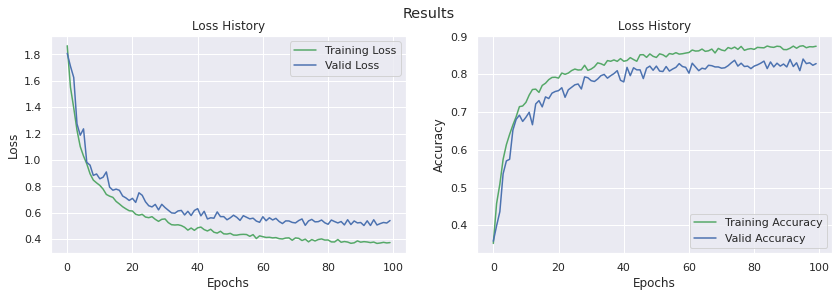

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

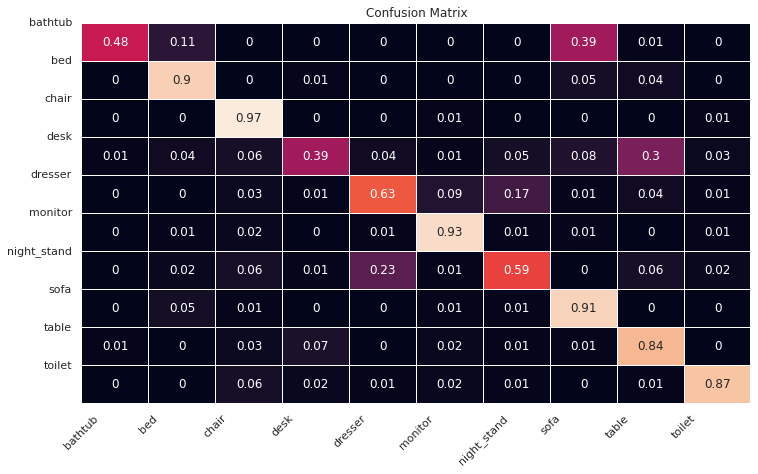

In [ ]:
trainer1.generateConfusionMatrix()

In [ ]:
trainer1.getPerClassAccuracy()

{'bathtub': 48.4848518371582, 'bed': 90.0, 'chair': 97.97979736328125, 'desk': 38.613861083984375, 'dresser': 63.63636779785156, 'monitor': 93.0, 'night_stand': 58.999996185302734, 'sofa': 91.919189453125, 'table': 84.84849548339844, 'toilet': 87.00000762939453}


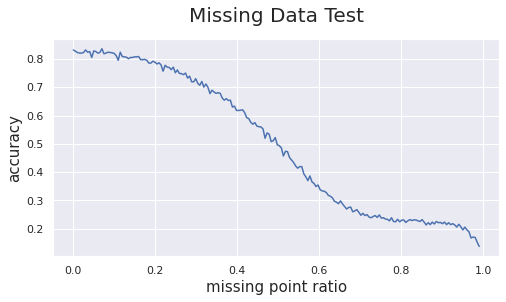

In [ ]:
trainer1.missing_data_test()

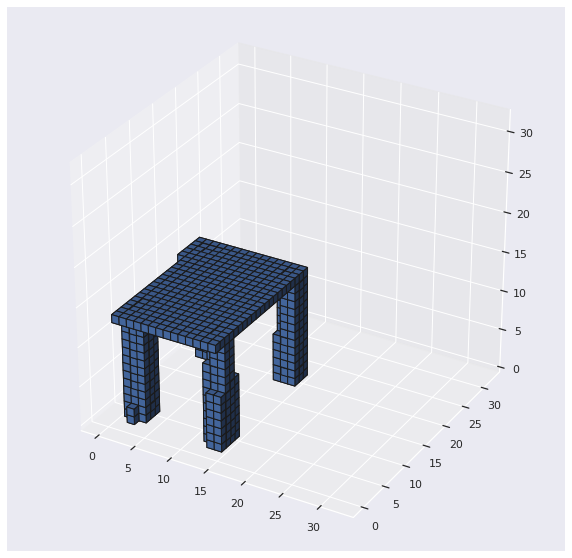

In [ ]:
trainer1.draw_voxels()

**BatchVoxNet** Training 

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'BatchVoxNet'
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

124.71875


Train loss: 1.5296926498413086: : 124it [01:19,  1.56it/s]
29it [00:10,  2.89it/s]


epoch:  1 /100
time: 89.50 seconds
train-loss: 1.68, train-acc: 41.96%
valid-loss: 1.52, valid-acc: 44.16%



Train loss: 0.9587723016738892: : 124it [01:18,  1.57it/s]
29it [00:10,  2.86it/s]


epoch:  2 /100
time: 89.09 seconds
train-loss: 1.23, train-acc: 57.41%
valid-loss: 1.21, valid-acc: 57.38%



Train loss: 1.0752785205841064: : 124it [01:17,  1.60it/s]
29it [00:10,  2.88it/s]


epoch:  3 /100
time: 87.71 seconds
train-loss: 1.02, train-acc: 64.31%
valid-loss: 1.03, valid-acc: 64.76%



Train loss: 1.055824875831604: : 124it [01:19,  1.56it/s]
29it [00:10,  2.86it/s]


epoch:  4 /100
time: 89.43 seconds
train-loss: 0.87, train-acc: 69.78%
valid-loss: 0.93, valid-acc: 66.08%



Train loss: 0.6438037753105164: : 124it [01:17,  1.60it/s]
29it [00:10,  2.86it/s]


epoch:  5 /100
time: 87.75 seconds
train-loss: 0.78, train-acc: 73.82%
valid-loss: 0.85, valid-acc: 68.61%



Train loss: 0.9464799165725708: : 124it [01:19,  1.57it/s]
29it [00:10,  2.88it/s]


epoch:  6 /100
time: 89.18 seconds
train-loss: 0.71, train-acc: 76.69%
valid-loss: 0.82, valid-acc: 69.93%



Train loss: 0.7892724871635437: : 124it [01:17,  1.60it/s]
29it [00:10,  2.89it/s]


epoch:  7 /100
time: 87.51 seconds
train-loss: 0.67, train-acc: 77.97%
valid-loss: 0.74, valid-acc: 73.79%



Train loss: 0.6944065093994141: : 124it [01:20,  1.54it/s]
29it [00:10,  2.83it/s]


epoch:  8 /100
time: 90.57 seconds
train-loss: 0.62, train-acc: 78.96%
valid-loss: 0.76, valid-acc: 74.89%



Train loss: 0.5059600472450256: : 124it [01:18,  1.57it/s]
29it [00:11,  2.60it/s]


epoch:  9 /100
time: 89.92 seconds
train-loss: 0.59, train-acc: 80.34%
valid-loss: 0.64, valid-acc: 75.66%



Train loss: 0.4503028988838196: : 124it [01:18,  1.58it/s]
29it [00:10,  2.76it/s]


epoch: 10 /100
time: 88.89 seconds
train-loss: 0.57, train-acc: 81.73%
valid-loss: 0.66, valid-acc: 75.77%



Train loss: 0.7085109949111938: : 124it [01:22,  1.51it/s]
29it [00:10,  2.78it/s]


epoch: 11 /100
time: 92.61 seconds
train-loss: 0.56, train-acc: 81.65%
valid-loss: 0.65, valid-acc: 76.54%



Train loss: 0.8034895062446594: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 12 /100
time: 89.38 seconds
train-loss: 0.53, train-acc: 82.43%
valid-loss: 0.87, valid-acc: 68.06%



Train loss: 0.26360854506492615: : 124it [01:20,  1.54it/s]
29it [00:10,  2.79it/s]


epoch: 13 /100
time: 90.87 seconds
train-loss: 0.52, train-acc: 82.91%
valid-loss: 0.59, valid-acc: 78.08%



Train loss: 0.3203951418399811: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 14 /100
time: 88.89 seconds
train-loss: 0.51, train-acc: 82.99%
valid-loss: 0.63, valid-acc: 78.19%



Train loss: 0.713444173336029: : 124it [01:20,  1.55it/s]
29it [00:10,  2.81it/s]


epoch: 15 /100
time: 90.34 seconds
train-loss: 0.47, train-acc: 84.53%
valid-loss: 0.62, valid-acc: 78.08%



Train loss: 0.29189613461494446: : 124it [01:19,  1.56it/s]
29it [00:11,  2.61it/s]


epoch: 16 /100
time: 90.60 seconds
train-loss: 0.44, train-acc: 85.81%
valid-loss: 0.57, valid-acc: 80.95%



Train loss: 0.326040655374527: : 124it [01:18,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 17 /100
time: 89.18 seconds
train-loss: 0.43, train-acc: 85.76%
valid-loss: 0.55, valid-acc: 81.61%



Train loss: 0.2907021641731262: : 124it [01:21,  1.53it/s]
29it [00:10,  2.74it/s]


epoch: 18 /100
time: 91.76 seconds
train-loss: 0.40, train-acc: 86.54%
valid-loss: 0.55, valid-acc: 82.27%



Train loss: 0.5200555920600891: : 124it [01:19,  1.56it/s]
29it [00:10,  2.78it/s]


epoch: 19 /100
time: 90.13 seconds
train-loss: 0.41, train-acc: 86.77%
valid-loss: 0.54, valid-acc: 81.17%



Train loss: 0.24374014139175415: : 124it [01:20,  1.54it/s]
29it [00:10,  2.81it/s]


epoch: 20 /100
time: 90.86 seconds
train-loss: 0.38, train-acc: 87.30%
valid-loss: 0.56, valid-acc: 81.61%



Train loss: 0.1631910353899002: : 124it [01:18,  1.57it/s]
29it [00:10,  2.80it/s]


epoch: 21 /100
time: 89.26 seconds
train-loss: 0.38, train-acc: 87.15%
valid-loss: 0.55, valid-acc: 81.17%



Train loss: 0.3521222174167633: : 124it [01:20,  1.55it/s]
29it [00:10,  2.81it/s]


epoch: 22 /100
time: 90.49 seconds
train-loss: 0.38, train-acc: 87.20%
valid-loss: 0.53, valid-acc: 82.71%



Train loss: 0.27627629041671753: : 124it [01:18,  1.58it/s]
29it [00:11,  2.44it/s]


epoch: 23 /100
time: 90.32 seconds
train-loss: 0.37, train-acc: 87.90%
valid-loss: 0.50, valid-acc: 82.16%



Train loss: 0.5305715799331665: : 124it [01:18,  1.58it/s]
29it [00:10,  2.84it/s]


epoch: 24 /100
time: 88.84 seconds
train-loss: 0.35, train-acc: 87.90%
valid-loss: 0.50, valid-acc: 81.28%



Train loss: 0.1900976449251175: : 124it [01:20,  1.54it/s]
29it [00:10,  2.78it/s]


epoch: 25 /100
time: 91.05 seconds
train-loss: 0.35, train-acc: 88.61%
valid-loss: 0.53, valid-acc: 82.71%



Train loss: 0.21390479803085327: : 124it [01:18,  1.57it/s]
29it [00:10,  2.82it/s]


epoch: 26 /100
time: 89.26 seconds
train-loss: 0.34, train-acc: 88.38%
valid-loss: 0.48, valid-acc: 84.80%



Train loss: 0.423173189163208: : 124it [01:20,  1.54it/s]
29it [00:10,  2.75it/s]


epoch: 27 /100
time: 91.21 seconds
train-loss: 0.34, train-acc: 89.06%
valid-loss: 0.56, valid-acc: 81.39%



Train loss: 0.4312545657157898: : 124it [01:19,  1.56it/s]
29it [00:10,  2.76it/s]


epoch: 28 /100
time: 90.21 seconds
train-loss: 0.33, train-acc: 88.63%
valid-loss: 0.47, valid-acc: 83.70%



Train loss: 0.30925923585891724: : 124it [01:20,  1.53it/s]
29it [00:10,  2.77it/s]


epoch: 29 /100
time: 91.49 seconds
train-loss: 0.32, train-acc: 88.73%
valid-loss: 0.55, valid-acc: 81.28%



Train loss: 0.0789952427148819: : 124it [01:18,  1.58it/s]
29it [00:10,  2.78it/s]


epoch: 30 /100
time: 88.95 seconds
train-loss: 0.31, train-acc: 89.26%
valid-loss: 0.51, valid-acc: 83.59%



Train loss: 0.28488415479660034: : 124it [01:20,  1.53it/s]
29it [00:10,  2.78it/s]


epoch: 31 /100
time: 91.42 seconds
train-loss: 0.31, train-acc: 89.16%
valid-loss: 0.51, valid-acc: 82.49%



Train loss: 0.2934674620628357: : 124it [01:18,  1.57it/s]
29it [00:10,  2.82it/s]


epoch: 32 /100
time: 89.18 seconds
train-loss: 0.30, train-acc: 90.20%
valid-loss: 0.47, valid-acc: 84.25%



Train loss: 0.36333033442497253: : 124it [01:20,  1.54it/s]
29it [00:10,  2.79it/s]


epoch: 33 /100
time: 90.84 seconds
train-loss: 0.28, train-acc: 90.25%
valid-loss: 0.50, valid-acc: 83.70%



Train loss: 0.36051487922668457: : 124it [01:20,  1.53it/s]
29it [00:10,  2.79it/s]


epoch: 34 /100
time: 91.26 seconds
train-loss: 0.28, train-acc: 90.42%
valid-loss: 0.45, valid-acc: 85.02%



Train loss: 0.3385767936706543: : 124it [01:19,  1.56it/s]
29it [00:10,  2.80it/s]


epoch: 35 /100
time: 89.89 seconds
train-loss: 0.29, train-acc: 90.27%
valid-loss: 0.47, valid-acc: 85.02%



Train loss: 0.49947959184646606: : 124it [01:20,  1.53it/s]
29it [00:10,  2.80it/s]


epoch: 36 /100
time: 91.25 seconds
train-loss: 0.27, train-acc: 91.00%
valid-loss: 0.46, valid-acc: 85.13%



Train loss: 0.17468518018722534: : 124it [01:19,  1.57it/s]
29it [00:10,  2.78it/s]


epoch: 37 /100
time: 89.64 seconds
train-loss: 0.27, train-acc: 90.47%
valid-loss: 0.46, valid-acc: 85.79%



Train loss: 0.2776069939136505: : 124it [01:21,  1.53it/s]
29it [00:10,  2.78it/s]


epoch: 38 /100
time: 91.58 seconds
train-loss: 0.27, train-acc: 91.05%
valid-loss: 0.45, valid-acc: 84.91%



Train loss: 0.15772481262683868: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 39 /100
time: 89.49 seconds
train-loss: 0.27, train-acc: 90.73%
valid-loss: 0.45, valid-acc: 84.69%



Train loss: 0.4661194682121277: : 124it [01:20,  1.53it/s]
29it [00:10,  2.82it/s]


epoch: 40 /100
time: 91.27 seconds
train-loss: 0.27, train-acc: 91.10%
valid-loss: 0.50, valid-acc: 84.69%



Train loss: 0.6079610586166382: : 124it [01:18,  1.57it/s]
29it [00:10,  2.77it/s]


epoch: 41 /100
time: 89.33 seconds
train-loss: 0.26, train-acc: 91.38%
valid-loss: 0.48, valid-acc: 83.15%



Train loss: 0.21626192331314087: : 124it [01:20,  1.54it/s]
29it [00:10,  2.81it/s]


epoch: 42 /100
time: 90.76 seconds
train-loss: 0.26, train-acc: 91.20%
valid-loss: 0.47, valid-acc: 85.35%



Train loss: 0.4783763885498047: : 124it [01:18,  1.58it/s]
29it [00:10,  2.77it/s]


epoch: 43 /100
time: 89.13 seconds
train-loss: 0.25, train-acc: 91.26%
valid-loss: 0.48, valid-acc: 84.58%



Train loss: 0.16417323052883148: : 124it [01:21,  1.52it/s]
29it [00:10,  2.79it/s]


epoch: 44 /100
time: 92.22 seconds
train-loss: 0.24, train-acc: 91.15%
valid-loss: 0.51, valid-acc: 85.35%



Train loss: 0.2959010899066925: : 124it [01:19,  1.56it/s]
29it [00:12,  2.38it/s]


epoch: 45 /100
time: 91.92 seconds
train-loss: 0.26, train-acc: 90.85%
valid-loss: 0.46, valid-acc: 84.80%



Train loss: 0.3570696711540222: : 124it [01:19,  1.55it/s]
29it [00:10,  2.78it/s]


epoch: 46 /100
time: 90.34 seconds
train-loss: 0.26, train-acc: 90.50%
valid-loss: 0.44, valid-acc: 87.00%



Train loss: 0.12239968031644821: : 124it [01:21,  1.52it/s]
29it [00:10,  2.74it/s]


epoch: 47 /100
time: 92.32 seconds
train-loss: 0.24, train-acc: 91.46%
valid-loss: 0.45, valid-acc: 85.02%



Train loss: 0.12843187153339386: : 124it [01:24,  1.46it/s]
29it [00:11,  2.51it/s]


epoch: 48 /100
time: 96.47 seconds
train-loss: 0.23, train-acc: 92.14%
valid-loss: 0.44, valid-acc: 86.01%



Train loss: 0.3419899642467499: : 124it [01:21,  1.53it/s]
29it [00:10,  2.79it/s]


epoch: 49 /100
time: 91.62 seconds
train-loss: 0.23, train-acc: 91.78%
valid-loss: 0.46, valid-acc: 85.57%



Train loss: 0.20529834926128387: : 124it [01:19,  1.57it/s]
29it [00:10,  2.80it/s]


epoch: 50 /100
time: 89.41 seconds
train-loss: 0.23, train-acc: 92.16%
valid-loss: 0.45, valid-acc: 85.02%



Train loss: 0.24354803562164307: : 124it [01:20,  1.54it/s]
29it [00:10,  2.81it/s]


epoch: 51 /100
time: 91.05 seconds
train-loss: 0.22, train-acc: 92.54%
valid-loss: 0.44, valid-acc: 84.14%



Train loss: 0.17813605070114136: : 124it [01:25,  1.44it/s]
29it [00:10,  2.82it/s]


epoch: 52 /100
time: 96.19 seconds
train-loss: 0.21, train-acc: 92.72%
valid-loss: 0.47, valid-acc: 84.69%



Train loss: 0.1383603811264038: : 124it [01:19,  1.55it/s]
29it [00:10,  2.81it/s]


epoch: 53 /100
time: 90.20 seconds
train-loss: 0.21, train-acc: 92.46%
valid-loss: 0.44, valid-acc: 85.46%



Train loss: 0.5026853084564209: : 124it [01:24,  1.46it/s]
29it [00:10,  2.82it/s]


epoch: 54 /100
time: 95.30 seconds
train-loss: 0.22, train-acc: 91.66%
valid-loss: 0.44, valid-acc: 86.56%



Train loss: 0.24905000627040863: : 124it [01:21,  1.53it/s]
29it [00:10,  2.77it/s]


epoch: 55 /100
time: 91.53 seconds
train-loss: 0.22, train-acc: 92.24%
valid-loss: 0.45, valid-acc: 84.69%



Train loss: 0.21543751657009125: : 124it [01:22,  1.51it/s]
29it [00:10,  2.79it/s]


epoch: 56 /100
time: 92.75 seconds
train-loss: 0.21, train-acc: 92.77%
valid-loss: 0.48, valid-acc: 84.36%



Train loss: 0.253947377204895: : 124it [01:19,  1.57it/s]
29it [00:10,  2.81it/s]


epoch: 57 /100
time: 89.48 seconds
train-loss: 0.21, train-acc: 92.24%
valid-loss: 0.46, valid-acc: 84.80%



Train loss: 0.1763768494129181: : 124it [01:21,  1.53it/s]
29it [00:10,  2.79it/s]


epoch: 58 /100
time: 91.53 seconds
train-loss: 0.20, train-acc: 93.27%
valid-loss: 0.45, valid-acc: 86.12%



Train loss: 0.2375691682100296: : 124it [01:18,  1.58it/s]
29it [00:10,  2.81it/s]


epoch: 59 /100
time: 89.01 seconds
train-loss: 0.22, train-acc: 92.49%
valid-loss: 0.46, valid-acc: 85.35%



Train loss: 0.07160932570695877: : 124it [01:20,  1.55it/s]
29it [00:10,  2.83it/s]


epoch: 60 /100
time: 90.53 seconds
train-loss: 0.20, train-acc: 92.89%
valid-loss: 0.46, valid-acc: 85.24%



Train loss: 0.3722746968269348: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 61 /100
time: 88.53 seconds
train-loss: 0.20, train-acc: 92.89%
valid-loss: 0.48, valid-acc: 86.34%



Train loss: 0.3815707266330719: : 124it [01:20,  1.55it/s]
29it [00:10,  2.81it/s]


epoch: 62 /100
time: 90.50 seconds
train-loss: 0.20, train-acc: 92.94%
valid-loss: 0.43, valid-acc: 85.90%



Train loss: 0.24823349714279175: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 63 /100
time: 88.59 seconds
train-loss: 0.20, train-acc: 93.15%
valid-loss: 0.45, valid-acc: 84.69%



Train loss: 0.09635449945926666: : 124it [01:20,  1.54it/s]
29it [00:10,  2.83it/s]


epoch: 64 /100
time: 90.87 seconds
train-loss: 0.19, train-acc: 93.27%
valid-loss: 0.47, valid-acc: 85.57%



Train loss: 0.22616387903690338: : 124it [01:18,  1.58it/s]
29it [00:10,  2.82it/s]


epoch: 65 /100
time: 88.82 seconds
train-loss: 0.19, train-acc: 93.25%
valid-loss: 0.43, valid-acc: 85.68%



Train loss: 0.2698628306388855: : 124it [01:20,  1.55it/s]
29it [00:10,  2.83it/s]


epoch: 66 /100
time: 90.41 seconds
train-loss: 0.20, train-acc: 93.04%
valid-loss: 0.44, valid-acc: 85.90%



Train loss: 0.13293294608592987: : 124it [01:18,  1.59it/s]
29it [00:10,  2.83it/s]


epoch: 67 /100
time: 88.41 seconds
train-loss: 0.19, train-acc: 93.27%
valid-loss: 0.45, valid-acc: 86.34%



Train loss: 0.27083244919776917: : 124it [01:19,  1.55it/s]
29it [00:10,  2.81it/s]


epoch: 68 /100
time: 90.33 seconds
train-loss: 0.19, train-acc: 93.15%
valid-loss: 0.45, valid-acc: 86.23%



Train loss: 0.21122105419635773: : 124it [01:18,  1.57it/s]
29it [00:10,  2.78it/s]


epoch: 69 /100
time: 89.28 seconds
train-loss: 0.18, train-acc: 93.20%
valid-loss: 0.45, valid-acc: 85.90%



Train loss: 0.2595148980617523: : 124it [01:20,  1.54it/s]
29it [00:10,  2.83it/s]


epoch: 70 /100
time: 90.54 seconds
train-loss: 0.19, train-acc: 93.35%
valid-loss: 0.47, valid-acc: 85.02%



Train loss: 0.25237414240837097: : 124it [01:18,  1.59it/s]
29it [00:10,  2.82it/s]


epoch: 71 /100
time: 88.39 seconds
train-loss: 0.17, train-acc: 94.00%
valid-loss: 0.44, valid-acc: 85.68%



Train loss: 0.08628461509943008: : 124it [01:19,  1.56it/s]
29it [00:10,  2.80it/s]


epoch: 72 /100
time: 90.07 seconds
train-loss: 0.18, train-acc: 93.50%
valid-loss: 0.47, valid-acc: 84.69%



Train loss: 0.10589253902435303: : 124it [01:18,  1.58it/s]
29it [00:10,  2.83it/s]


epoch: 73 /100
time: 88.80 seconds
train-loss: 0.18, train-acc: 93.57%
valid-loss: 0.46, valid-acc: 85.90%



Train loss: 0.11034417152404785: : 124it [01:20,  1.55it/s]
29it [00:10,  2.84it/s]


epoch: 74 /100
time: 90.25 seconds
train-loss: 0.17, train-acc: 93.78%
valid-loss: 0.48, valid-acc: 86.23%



Train loss: 0.07888588309288025: : 124it [01:18,  1.59it/s]
29it [00:10,  2.84it/s]


epoch: 75 /100
time: 88.36 seconds
train-loss: 0.17, train-acc: 94.15%
valid-loss: 0.48, valid-acc: 85.90%



Train loss: 0.2800956964492798: : 124it [01:19,  1.55it/s]
29it [00:10,  2.85it/s]


epoch: 76 /100
time: 90.19 seconds
train-loss: 0.18, train-acc: 93.70%
valid-loss: 0.46, valid-acc: 85.13%



Train loss: 0.19856083393096924: : 124it [01:17,  1.60it/s]
29it [00:10,  2.86it/s]


epoch: 77 /100
time: 87.69 seconds
train-loss: 0.17, train-acc: 93.95%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.03707364574074745: : 124it [01:19,  1.57it/s]
29it [00:10,  2.86it/s]


epoch: 78 /100
time: 89.38 seconds
train-loss: 0.17, train-acc: 93.70%
valid-loss: 0.47, valid-acc: 85.90%



Train loss: 0.2798512578010559: : 124it [01:17,  1.59it/s]
29it [00:10,  2.87it/s]


epoch: 79 /100
time: 88.02 seconds
train-loss: 0.17, train-acc: 93.88%
valid-loss: 0.46, valid-acc: 86.12%



Train loss: 0.18370231986045837: : 124it [01:19,  1.56it/s]
29it [00:10,  2.84it/s]


epoch: 80 /100
time: 89.93 seconds
train-loss: 0.17, train-acc: 94.30%
valid-loss: 0.44, valid-acc: 86.01%



Train loss: 0.11752988398075104: : 124it [01:18,  1.58it/s]
29it [00:10,  2.87it/s]


epoch: 81 /100
time: 88.48 seconds
train-loss: 0.17, train-acc: 93.95%
valid-loss: 0.47, valid-acc: 85.46%



Train loss: 0.2289503663778305: : 124it [01:17,  1.59it/s]
29it [00:11,  2.47it/s]


epoch: 82 /100
time: 89.64 seconds
train-loss: 0.16, train-acc: 94.03%
valid-loss: 0.46, valid-acc: 84.58%



Train loss: 0.15982073545455933: : 124it [01:18,  1.59it/s]
29it [00:10,  2.83it/s]


epoch: 83 /100
time: 88.29 seconds
train-loss: 0.15, train-acc: 94.86%
valid-loss: 0.45, valid-acc: 86.34%



Train loss: 0.11560731381177902: : 124it [01:18,  1.58it/s]
29it [00:10,  2.76it/s]


epoch: 84 /100
time: 89.13 seconds
train-loss: 0.16, train-acc: 94.03%
valid-loss: 0.45, valid-acc: 87.22%



Train loss: 0.088625468313694: : 124it [01:19,  1.55it/s]
29it [00:10,  2.83it/s]


epoch: 85 /100
time: 90.24 seconds
train-loss: 0.17, train-acc: 94.15%
valid-loss: 0.44, valid-acc: 87.00%



Train loss: 0.07170116901397705: : 124it [01:17,  1.59it/s]
29it [00:10,  2.84it/s]


epoch: 86 /100
time: 88.10 seconds
train-loss: 0.15, train-acc: 94.68%
valid-loss: 0.46, valid-acc: 86.78%



Train loss: 0.42437493801116943: : 124it [01:19,  1.56it/s]
29it [00:10,  2.85it/s]


epoch: 87 /100
time: 89.76 seconds
train-loss: 0.16, train-acc: 94.20%
valid-loss: 0.44, valid-acc: 86.56%



Train loss: 0.18134254217147827: : 124it [01:18,  1.59it/s]
29it [00:10,  2.83it/s]


epoch: 88 /100
time: 88.29 seconds
train-loss: 0.16, train-acc: 94.23%
valid-loss: 0.46, valid-acc: 87.11%



Train loss: 0.21533600986003876: : 124it [01:19,  1.56it/s]
29it [00:10,  2.86it/s]


epoch: 89 /100
time: 89.63 seconds
train-loss: 0.16, train-acc: 94.46%
valid-loss: 0.45, valid-acc: 86.67%



Train loss: 0.1595424860715866: : 124it [01:26,  1.43it/s]
29it [00:13,  2.12it/s]


epoch: 90 /100
time: 100.22 seconds
train-loss: 0.17, train-acc: 94.08%
valid-loss: 0.49, valid-acc: 85.24%



Train loss: 0.11085513234138489: : 124it [01:21,  1.51it/s]
29it [00:10,  2.84it/s]


epoch: 91 /100
time: 92.15 seconds
train-loss: 0.15, train-acc: 94.13%
valid-loss: 0.47, valid-acc: 86.12%



Train loss: 0.07176351547241211: : 124it [01:20,  1.55it/s]
29it [00:10,  2.82it/s]


epoch: 92 /100
time: 90.54 seconds
train-loss: 0.17, train-acc: 94.10%
valid-loss: 0.47, valid-acc: 87.22%



Train loss: 0.06626306474208832: : 124it [01:20,  1.54it/s]
29it [00:10,  2.81it/s]


epoch: 93 /100
time: 90.79 seconds
train-loss: 0.15, train-acc: 94.88%
valid-loss: 0.45, valid-acc: 85.79%



Train loss: 0.11470324546098709: : 124it [01:18,  1.59it/s]
29it [00:10,  2.84it/s]


epoch: 94 /100
time: 88.40 seconds
train-loss: 0.16, train-acc: 94.30%
valid-loss: 0.47, valid-acc: 86.45%



Train loss: 0.40116456151008606: : 124it [01:19,  1.56it/s]
29it [00:10,  2.84it/s]


epoch: 95 /100
time: 89.85 seconds
train-loss: 0.16, train-acc: 94.43%
valid-loss: 0.45, valid-acc: 87.00%



Train loss: 0.29216670989990234: : 124it [01:17,  1.60it/s]
29it [00:10,  2.87it/s]


epoch: 96 /100
time: 87.86 seconds
train-loss: 0.16, train-acc: 94.53%
valid-loss: 0.42, valid-acc: 87.56%



Train loss: 0.06048104912042618: : 124it [01:19,  1.56it/s]
29it [00:10,  2.86it/s]


epoch: 97 /100
time: 89.59 seconds
train-loss: 0.15, train-acc: 94.61%
valid-loss: 0.45, valid-acc: 86.23%



Train loss: 0.4277550280094147: : 124it [01:17,  1.59it/s]
29it [00:10,  2.88it/s]


epoch: 98 /100
time: 87.94 seconds
train-loss: 0.15, train-acc: 94.63%
valid-loss: 0.46, valid-acc: 87.33%



Train loss: 0.16619661450386047: : 124it [01:17,  1.60it/s]
29it [00:11,  2.45it/s]


epoch: 99 /100
time: 89.55 seconds
train-loss: 0.15, train-acc: 94.76%
valid-loss: 0.45, valid-acc: 86.01%



Train loss: 0.05075662583112717: : 124it [01:17,  1.59it/s]
29it [00:10,  2.84it/s]

epoch:100 /100
time: 88.11 seconds
train-loss: 0.15, train-acc: 94.71%
valid-loss: 0.45, valid-acc: 85.90%



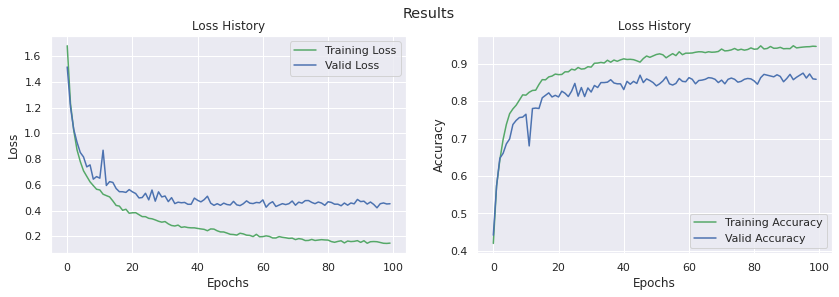

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

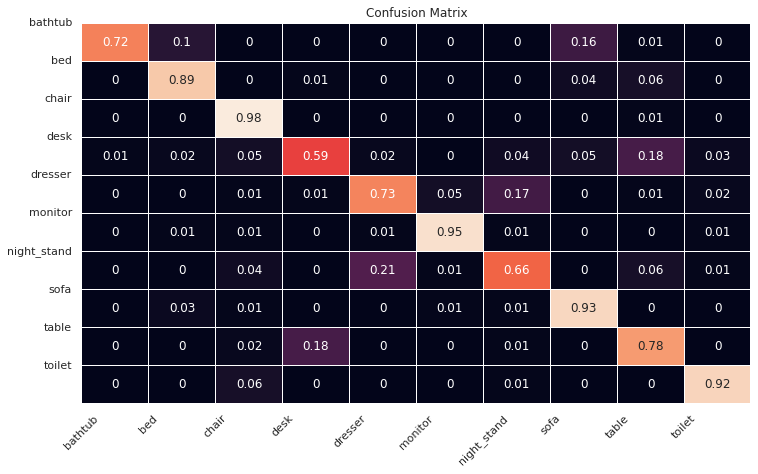

In [ ]:
trainer2.generateConfusionMatrix()

In [ ]:
trainer2.getPerClassAccuracy()

{'bathtub': 72.7272720336914, 'bed': 89.0, 'chair': 98.98989868164062, 'desk': 59.59595489501953, 'dresser': 73.0, 'monitor': 95.0, 'night_stand': 66.66666412353516, 'sofa': 93.93939208984375, 'table': 78.78787994384766, 'toilet': 92.92929077148438}


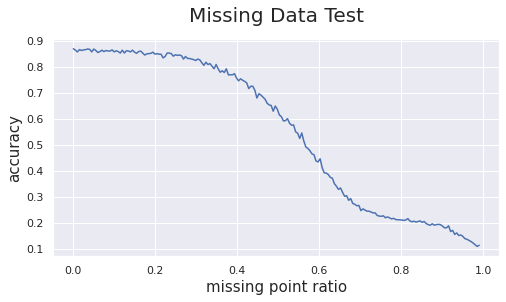

In [ ]:
trainer2.missing_data_test()

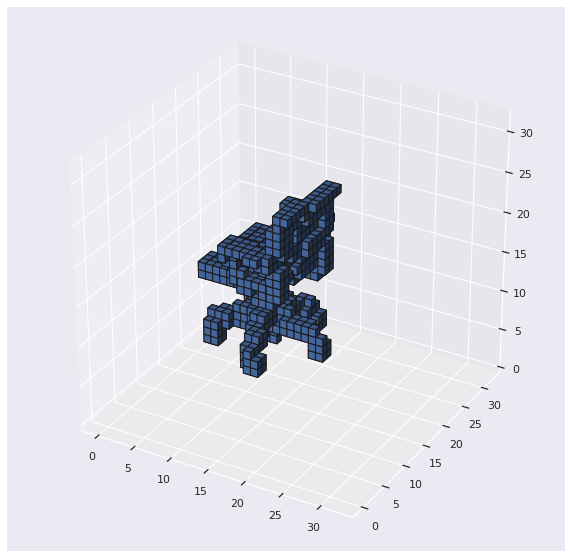

In [ ]:
trainer2.draw_voxels()

**DMPVoxNet** training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet'
}    

trainer3 = VoxNet_Trainer(training_hyperparameters)
trainer3.train()

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


124.71875


Train loss: 1.6378803253173828: : 124it [00:58,  2.12it/s]
29it [00:09,  3.16it/s]


epoch:  1 /100
time: 67.58 seconds
train-loss: 1.85, train-acc: 35.89%
valid-loss: 1.80, valid-acc: 33.04%



Train loss: 1.4627498388290405: : 124it [00:59,  2.09it/s]
29it [00:08,  3.22it/s]


epoch:  2 /100
time: 68.48 seconds
train-loss: 1.52, train-acc: 47.08%
valid-loss: 1.66, valid-acc: 36.78%



Train loss: 1.6337649822235107: : 124it [00:56,  2.18it/s]
29it [00:08,  3.28it/s]


epoch:  3 /100
time: 65.70 seconds
train-loss: 1.33, train-acc: 52.57%
valid-loss: 1.41, valid-acc: 47.36%



Train loss: 1.3269963264465332: : 124it [00:56,  2.19it/s]
29it [00:10,  2.75it/s]


epoch:  4 /100
time: 67.26 seconds
train-loss: 1.21, train-acc: 57.59%
valid-loss: 1.25, valid-acc: 56.17%



Train loss: 0.9105241298675537: : 124it [00:56,  2.19it/s]
29it [00:08,  3.29it/s]


epoch:  5 /100
time: 65.52 seconds
train-loss: 1.09, train-acc: 61.67%
valid-loss: 1.13, valid-acc: 60.57%



Train loss: 1.3970588445663452: : 124it [00:56,  2.18it/s]
29it [00:08,  3.28it/s]


epoch:  6 /100
time: 65.70 seconds
train-loss: 1.03, train-acc: 65.05%
valid-loss: 1.11, valid-acc: 61.67%



Train loss: 1.2061395645141602: : 124it [00:59,  2.08it/s]
29it [00:09,  3.12it/s]


epoch:  7 /100
time: 68.88 seconds
train-loss: 0.96, train-acc: 67.62%
valid-loss: 1.01, valid-acc: 66.19%



Train loss: 0.8789446353912354: : 124it [00:58,  2.11it/s]
29it [00:09,  3.11it/s]


epoch:  8 /100
time: 67.99 seconds
train-loss: 0.91, train-acc: 68.90%
valid-loss: 0.99, valid-acc: 63.99%



Train loss: 0.5434911251068115: : 124it [01:00,  2.05it/s]
29it [00:09,  3.14it/s]


epoch:  9 /100
time: 69.70 seconds
train-loss: 0.86, train-acc: 71.42%
valid-loss: 0.98, valid-acc: 64.98%



Train loss: 0.9570983052253723: : 124it [00:58,  2.11it/s]
29it [00:09,  3.11it/s]


epoch: 10 /100
time: 68.03 seconds
train-loss: 0.82, train-acc: 72.48%
valid-loss: 0.91, valid-acc: 68.83%



Train loss: 0.7418861389160156: : 124it [00:58,  2.14it/s]
29it [00:10,  2.71it/s]


epoch: 11 /100
time: 68.76 seconds
train-loss: 0.83, train-acc: 72.66%
valid-loss: 0.88, valid-acc: 69.93%



Train loss: 0.7568076252937317: : 124it [00:56,  2.18it/s]
29it [00:08,  3.26it/s]


epoch: 12 /100
time: 65.90 seconds
train-loss: 0.78, train-acc: 73.64%
valid-loss: 0.87, valid-acc: 70.26%



Train loss: 0.9040109515190125: : 124it [00:56,  2.18it/s]
29it [00:08,  3.26it/s]


epoch: 13 /100
time: 65.77 seconds
train-loss: 0.76, train-acc: 73.44%
valid-loss: 0.84, valid-acc: 68.72%



Train loss: 0.4930453598499298: : 124it [00:58,  2.11it/s]
29it [00:08,  3.25it/s]


epoch: 14 /100
time: 67.83 seconds
train-loss: 0.75, train-acc: 74.02%
valid-loss: 0.84, valid-acc: 73.13%



Train loss: 0.9457195401191711: : 124it [00:57,  2.17it/s]
29it [00:09,  3.21it/s]


epoch: 15 /100
time: 66.16 seconds
train-loss: 0.72, train-acc: 74.92%
valid-loss: 0.86, valid-acc: 69.38%



Train loss: 0.6636264324188232: : 124it [00:58,  2.11it/s]
29it [00:08,  3.27it/s]


epoch: 16 /100
time: 67.64 seconds
train-loss: 0.69, train-acc: 77.27%
valid-loss: 0.78, valid-acc: 72.69%



Train loss: 0.8116118907928467: : 124it [00:57,  2.17it/s]
29it [00:08,  3.25it/s]


epoch: 17 /100
time: 66.04 seconds
train-loss: 0.67, train-acc: 76.86%
valid-loss: 0.78, valid-acc: 72.03%



Train loss: 0.23708081245422363: : 124it [00:57,  2.17it/s]
29it [00:09,  3.19it/s]


epoch: 18 /100
time: 66.16 seconds
train-loss: 0.65, train-acc: 77.92%
valid-loss: 0.78, valid-acc: 71.48%



Train loss: 0.7766640186309814: : 124it [00:58,  2.12it/s]
29it [00:08,  3.27it/s]


epoch: 19 /100
time: 67.36 seconds
train-loss: 0.64, train-acc: 78.50%
valid-loss: 0.77, valid-acc: 74.01%



Train loss: 0.5176842212677002: : 124it [00:56,  2.18it/s]
29it [00:08,  3.27it/s]


epoch: 20 /100
time: 65.74 seconds
train-loss: 0.66, train-acc: 77.75%
valid-loss: 0.75, valid-acc: 72.91%



Train loss: 0.43799784779548645: : 124it [00:58,  2.12it/s]
29it [00:08,  3.28it/s]


epoch: 21 /100
time: 67.48 seconds
train-loss: 0.63, train-acc: 78.76%
valid-loss: 0.71, valid-acc: 75.11%



Train loss: 0.3300509452819824: : 124it [00:56,  2.18it/s]
29it [00:08,  3.24it/s]


epoch: 22 /100
time: 65.81 seconds
train-loss: 0.61, train-acc: 79.54%
valid-loss: 0.74, valid-acc: 74.45%



Train loss: 0.4429812431335449: : 124it [00:58,  2.11it/s]
29it [00:08,  3.24it/s]


epoch: 23 /100
time: 67.69 seconds
train-loss: 0.60, train-acc: 78.58%
valid-loss: 0.74, valid-acc: 74.45%



Train loss: 0.48753219842910767: : 124it [00:56,  2.19it/s]
29it [00:08,  3.25it/s]


epoch: 24 /100
time: 65.65 seconds
train-loss: 0.60, train-acc: 80.14%
valid-loss: 0.74, valid-acc: 74.56%



Train loss: 0.8104776740074158: : 124it [00:57,  2.17it/s]
29it [00:08,  3.27it/s]


epoch: 25 /100
time: 65.98 seconds
train-loss: 0.57, train-acc: 80.62%
valid-loss: 0.69, valid-acc: 77.86%



Train loss: 0.5613169074058533: : 124it [00:58,  2.12it/s]
29it [00:08,  3.27it/s]


epoch: 26 /100
time: 67.43 seconds
train-loss: 0.60, train-acc: 80.34%
valid-loss: 0.77, valid-acc: 72.69%



Train loss: 1.0634220838546753: : 124it [00:56,  2.19it/s]
29it [00:08,  3.29it/s]


epoch: 27 /100
time: 65.35 seconds
train-loss: 0.58, train-acc: 80.65%
valid-loss: 0.67, valid-acc: 78.30%



Train loss: 1.1517976522445679: : 124it [00:58,  2.13it/s]
29it [00:08,  3.28it/s]


epoch: 28 /100
time: 67.13 seconds
train-loss: 0.58, train-acc: 79.89%
valid-loss: 0.68, valid-acc: 77.09%



Train loss: 0.48719143867492676: : 124it [00:56,  2.19it/s]
29it [00:08,  3.28it/s]


epoch: 29 /100
time: 65.53 seconds
train-loss: 0.57, train-acc: 81.00%
valid-loss: 0.66, valid-acc: 79.07%



Train loss: 0.21762236952781677: : 124it [00:57,  2.15it/s]
29it [00:09,  2.99it/s]


epoch: 30 /100
time: 67.32 seconds
train-loss: 0.58, train-acc: 80.62%
valid-loss: 0.69, valid-acc: 75.33%



Train loss: 0.6786878705024719: : 124it [00:56,  2.19it/s]
29it [00:08,  3.23it/s]


epoch: 31 /100
time: 65.72 seconds
train-loss: 0.55, train-acc: 81.43%
valid-loss: 0.65, valid-acc: 76.98%



Train loss: 0.4941784739494324: : 124it [00:56,  2.18it/s]
29it [00:08,  3.24it/s]


epoch: 32 /100
time: 65.86 seconds
train-loss: 0.53, train-acc: 82.66%
valid-loss: 0.66, valid-acc: 77.86%



Train loss: 0.3508850038051605: : 124it [00:58,  2.13it/s]
29it [00:08,  3.25it/s]


epoch: 33 /100
time: 67.30 seconds
train-loss: 0.52, train-acc: 82.41%
valid-loss: 0.62, valid-acc: 80.62%



Train loss: 0.37130966782569885: : 124it [00:56,  2.19it/s]
29it [00:08,  3.29it/s]


epoch: 34 /100
time: 65.45 seconds
train-loss: 0.52, train-acc: 82.56%
valid-loss: 0.64, valid-acc: 79.63%



Train loss: 0.4098348319530487: : 124it [00:58,  2.12it/s]
29it [00:08,  3.23it/s]


epoch: 35 /100
time: 67.63 seconds
train-loss: 0.50, train-acc: 83.44%
valid-loss: 0.64, valid-acc: 77.53%



Train loss: 0.7005933523178101: : 124it [00:56,  2.19it/s]
29it [00:08,  3.25it/s]


epoch: 36 /100
time: 65.58 seconds
train-loss: 0.51, train-acc: 82.99%
valid-loss: 0.67, valid-acc: 77.86%



Train loss: 0.4686000347137451: : 124it [00:59,  2.08it/s]
29it [00:08,  3.23it/s]


epoch: 37 /100
time: 68.54 seconds
train-loss: 0.51, train-acc: 83.52%
valid-loss: 0.63, valid-acc: 78.96%



Train loss: 0.44000616669654846: : 124it [00:56,  2.18it/s]
29it [00:08,  3.25it/s]


epoch: 38 /100
time: 65.80 seconds
train-loss: 0.50, train-acc: 83.57%
valid-loss: 0.65, valid-acc: 79.74%



Train loss: 0.30341342091560364: : 124it [00:56,  2.18it/s]
29it [00:08,  3.28it/s]


epoch: 39 /100
time: 65.69 seconds
train-loss: 0.47, train-acc: 83.64%
valid-loss: 0.62, valid-acc: 80.95%



Train loss: 0.4889630973339081: : 124it [00:58,  2.12it/s]
29it [00:08,  3.23it/s]


epoch: 40 /100
time: 67.58 seconds
train-loss: 0.51, train-acc: 83.29%
valid-loss: 0.64, valid-acc: 79.07%



Train loss: 0.47573357820510864: : 124it [00:57,  2.17it/s]
29it [00:10,  2.69it/s]


epoch: 41 /100
time: 67.85 seconds
train-loss: 0.47, train-acc: 84.30%
valid-loss: 0.61, valid-acc: 80.95%



Train loss: 0.5304743647575378: : 124it [01:15,  1.65it/s]
29it [00:12,  2.25it/s]


epoch: 42 /100
time: 87.96 seconds
train-loss: 0.50, train-acc: 82.94%
valid-loss: 0.63, valid-acc: 78.85%



Train loss: 0.4876270592212677: : 124it [00:59,  2.07it/s]
29it [00:09,  3.10it/s]


epoch: 43 /100
time: 69.39 seconds
train-loss: 0.49, train-acc: 83.47%
valid-loss: 0.60, valid-acc: 79.85%



Train loss: 0.6302680969238281: : 124it [01:18,  1.57it/s]
29it [00:11,  2.59it/s]


epoch: 44 /100
time: 90.20 seconds
train-loss: 0.48, train-acc: 82.86%
valid-loss: 0.62, valid-acc: 79.19%



Train loss: 0.3952186703681946: : 124it [01:19,  1.57it/s]
29it [00:09,  3.03it/s]


epoch: 45 /100
time: 88.80 seconds
train-loss: 0.49, train-acc: 83.22%
valid-loss: 0.60, valid-acc: 81.72%



Train loss: 0.28294995427131653: : 124it [01:07,  1.83it/s]
29it [00:10,  2.87it/s]


epoch: 46 /100
time: 77.90 seconds
train-loss: 0.47, train-acc: 84.27%
valid-loss: 0.62, valid-acc: 79.07%



Train loss: 0.22672687470912933: : 124it [01:20,  1.54it/s]
29it [00:08,  3.24it/s]


epoch: 47 /100
time: 89.71 seconds
train-loss: 0.47, train-acc: 84.60%
valid-loss: 0.60, valid-acc: 81.28%



Train loss: 0.5083039402961731: : 124it [01:02,  1.97it/s]
29it [00:16,  1.80it/s]


epoch: 48 /100
time: 79.06 seconds
train-loss: 0.46, train-acc: 84.40%
valid-loss: 0.61, valid-acc: 79.30%



Train loss: 0.30729755759239197: : 124it [01:11,  1.73it/s]
29it [00:09,  3.19it/s]


epoch: 49 /100
time: 80.71 seconds
train-loss: 0.47, train-acc: 84.53%
valid-loss: 0.58, valid-acc: 79.74%



Train loss: 0.5579772591590881: : 124it [01:19,  1.57it/s]
29it [00:14,  1.98it/s]


epoch: 50 /100
time: 93.70 seconds
train-loss: 0.44, train-acc: 85.16%
valid-loss: 0.59, valid-acc: 81.61%



Train loss: 0.3886735141277313: : 124it [01:13,  1.70it/s]
29it [00:14,  2.04it/s]


epoch: 51 /100
time: 87.43 seconds
train-loss: 0.43, train-acc: 84.88%
valid-loss: 0.59, valid-acc: 81.06%



Train loss: 0.49522799253463745: : 77it [00:36,  2.12it/s]


KeyboardInterrupt: ignored

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

In [ ]:
trainer3.generateConfusionMatrix()

In [ ]:
trainer3.getPerClassAccuracy()

In [ ]:
trainer3.missing_data_test()

In [ ]:
trainer3.draw_voxels()

Results

In [ ]:
eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Results')
        
ax[0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0].plot(eps, smooth(history3["train_loss"].cpu()), 'g', label='Training Loss BVoxNet')
ax[0].plot(eps, smooth(history3["train_loss"].cpu()), 'g', label='Training Loss DMPVoxNet')
ax[0].set_title('Training Loss History')
ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].legend()
        
ax[1].plot(eps, smooth(history1["valid_loss"].cpu()), 'b', label='Valid Loss VoxNet')
ax[1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[1].plot(eps, smooth(history3["valid_loss"].cpu()), 'b', label='Valid Loss DMPVoxNet')
ax[1].set_title('Valid Loss History')
ax[1].set(xlabel='Epochs', ylabel='Loss')
ax[1].legend()

ax[2].plot(eps, smooth(history1["train_acc"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[2].plot(eps, smooth(history1["train_acc"].cpu()), 'g', label='Training Accuracy BVoxNet')
ax[2].plot(eps, smooth(history1["train_acc"].cpu()), 'g', label='Training Accuracy DMPVoxNet')
ax[2].set_title('Training Accuracy History')
ax[2].set(xlabel='Epochs', ylabel='Accuracy')
ax[2].legend()

ax[3].plot(eps, smooth(history1["valid_acc"].cpu()), 'b', label='Valid Accuracy VoxNet')
ax[3].plot(eps, smooth(history2["valid_acc"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[3].plot(eps, smooth(history3["valid_acc"].cpu()), 'b', label='Valid Accuracy DMPVoxNet')
ax[3].set_title('Valid Accuracy History')
ax[3].set(xlabel='Epochs', ylabel='Accuracy')
ax[3].legend()